In [1]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 783.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 918.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 2.1 MB/s eta 0:00:00


In [11]:
from pathlib import Path
import requests
import pickle
import gzip

DATA=Path("data")
PATH=DATA/"mnist"


PATH.mkdir(parents=True,exist_ok=True)
URL="https://github.com/pytorch/tutorials/raw/main/_static/"
File="mnist.pkl.gz"


if not (PATH/File).exists():
    content=requests.get(URL+File).content
    (PATH/File).open('wb').write(content)



In [12]:
p=Path('.')
[x for x in p.iterdir() if x.is_dir()]

[PosixPath('.config'), PosixPath('data'), PosixPath('sample_data')]

In [67]:
with gzip.open((PATH/File).as_posix(),'rb') as f:
  ((xtrain,ytrain),(xvalid,yvalid),_)=pickle.load(f,encoding="latin-1")

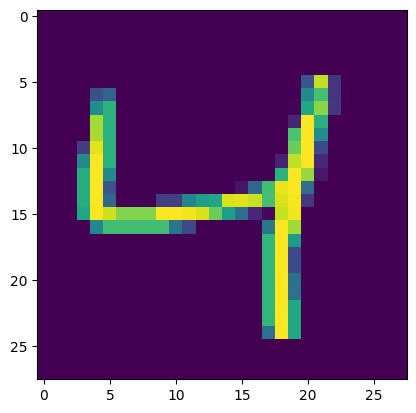

In [68]:
from matplotlib import pyplot
import numpy as np
import pandas as pd

pyplot.imshow(xtrain[2].reshape((28,28)))





In [58]:
xtrain[0].T.shape

(784,)

In [122]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [123]:
data = pd.read_csv('/content/drive/MyDrive/NeutralNetwork/train.csv')
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [116]:
def init():
  w1=np.random.rand(10,784)
  b1=np.random.rand(10,1)
  w2=np.random.rand(10,10)
  b2=np.random.rand(10,1)
  return w1,w2,b1,b2

def relu(X):

  return np.maximum(X,0)

def softmax(X):
  return np.exp(X)/sum(np.exp(X))

def der_sm(X):
  return X > 0
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def forward(w1,w2,b1,b2,x):
  z1=w1.dot(x)+b1
  a1=relu(z1)

  z2=w2.dot(a1)+b2
  a2=softmax(z2)
  return z1,a1,z2,a2

def backprop(z1,a1,z2,a2,w2,X,Y):
    m=Y.size
    one_y=one_hot(Y)
    dz2=a2-one_y
    dw2=(1/m)*dz2.dot(a1.T)
    db2=(1/m)*np.sum(dz2)
    dz1=w2.T.dot(dz2)*der_sm(z1)
    dw1=(1/m)*(dz1.dot(X.T))
    db1=(1/m)*(sum(dz1))
    return dw1,db1,dw2,db2

def update(w1,b1,w2,b2,dw1,dw2,db1,db2,a):
  w1=w1-(a*dw1)
  w2=w2-(a*dw2)
  b1=b1=(a*db1)
  b2=b2-(a*db2)
  return w1,w2,b1,b2


In [117]:
def get_pred(a2):
  return np.argmax(a2,0)


def get_accur(pred,Y):
  print(pred,Y)
  return np.sum(pred==Y)/Y.size

def gradient(X,Y,epoch,a):
  w1,w2,b1,b2=init()
  for i in range(epoch):
    z1,a1,z2,a2=forward(w1,w2,b1,b2,X)
    dw1,db1,dw2,db2=backprop(z1,a1,z2,a1,w2,X,Y)
    w1,w2,b1,b2=update(w1,b1,w2,b2,dw1,dw2,db1,db2,a)
    if i%50==0:
      print("Iteration:",i)
      print("Accuracy:",get_accur(get_pred(a2),Y))
  return w1,b1,w2,b2


In [114]:
xtrain=xtrain.T

In [124]:
w1,b1,w2,b2=gradient(X_train,Y_train,100,0.100)

ValueError: shapes (10,784) and (1,27000) not aligned: 784 (dim 1) != 1 (dim 0)

In [84]:
print(weights)

tensor([[ 0.0811, -0.0323, -0.0207,  ..., -0.0047, -0.0098,  0.0381],
        [ 0.0029, -0.0057,  0.0381,  ..., -0.0321, -0.0139, -0.0187],
        [-0.0717, -0.0306,  0.0109,  ..., -0.0124, -0.0097,  0.0197],
        ...,
        [-0.0197,  0.0138, -0.0521,  ...,  0.0048,  0.0106, -0.0341],
        [-0.0352,  0.0593, -0.0615,  ..., -0.0324, -0.0101,  0.0588],
        [ 0.0028, -0.0353,  0.0379,  ...,  0.0699,  0.0244, -0.0411]],
       requires_grad=True)
